In [1]:
import os, cv2, copy
import numpy as np
from util import parseMKV, exportCalib, tcp2base, target2cam

%matplotlib widget

os.chdir(globals()['_dh'][0])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dir = "./mkv_calib"

debug = False
matForm = False

exportCalibration = False
exportFrames = False
exportRobotPose = False
exportPoseEstimation = False

In [3]:
if exportCalibration:
    mtx, dist = exportCalib(dir = dir, debug = debug)
else:
    data = np.load("%s/calibration.npz" % dir)
    
    mtx = data["mtx"]
    dist = data["dist"]

if exportFrames:
    parseMKV(dir = dir, exportDepth = False, debug = debug)

if exportRobotPose:
    t_tcp2base, rVec_tcp2base, rMat_tcp2base, q_tcp2base = tcp2base(dir = dir)
else:
    data = np.load("%s/tcp2base.npz" % dir)

    t_tcp2base = data["t"]
    rVec_tcp2base = data["rVec"]
    rMat_tcp2base = data["rMat"]
    q_tcp2base = data["q"]

if exportPoseEstimation:
    rVec_target2cam, rMat_target2cam, t_target2cam = target2cam(dir = dir, mtx = mtx, dist = dist,
                                                                rx=copy.deepcopy(rVec_tcp2base),
                                                                tx=copy.deepcopy(t_tcp2base), 
                                                                boardDim = 24.9, debug = debug)
else:
    data = np.load("%s/target2cam.npz" % dir)

    t_target2cam = data["t"]
    rVec_target2cam = data["rVec"]
    rMat_target2cam = data["rMat"]

initialize camera pose visualizer


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
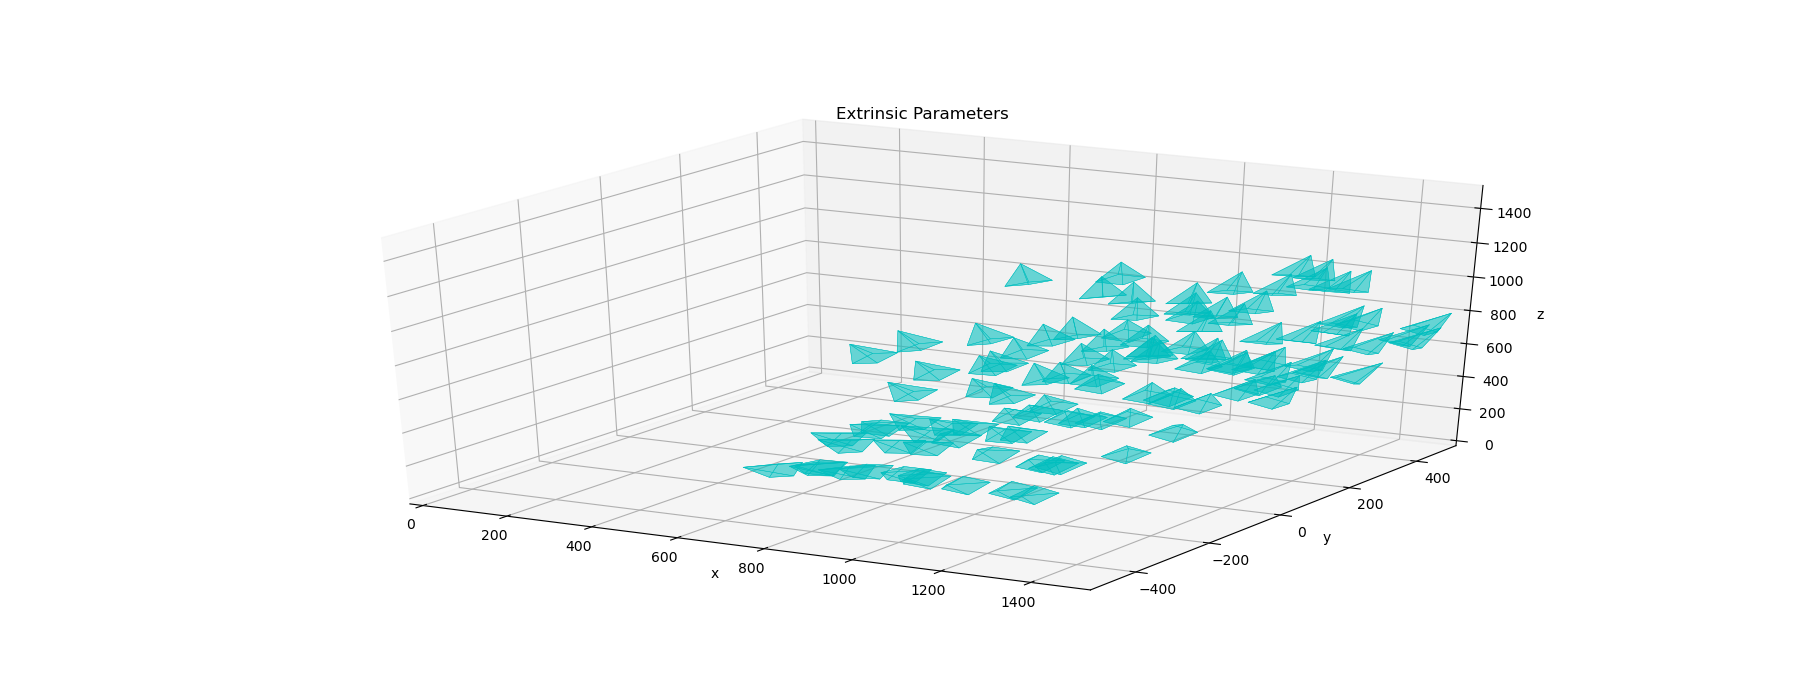

In [4]:
from visualizer import CameraPoseVisualizer
from scipy.spatial.transform import Rotation

visualizer = CameraPoseVisualizer([0, 1500], [-500, 500], [0, 1500])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for i in range(len(t_tcp2base)):
    exMtx = np.identity(4)
    exMtx[0:3,3] = t_tcp2base[i].ravel()    
    exMtx[0:3,0:3] = rMat_tcp2base[i]
    visualizer.extrinsic2pyramid(exMtx, 'c', 100)

visualizer.show()

In [5]:
if matForm:
    R_tcp2base = rMat_tcp2base
    R_target2cam = rMat_target2cam
else:
    R_tcp2base = rVec_tcp2base
    R_target2cam = rVec_target2cam

methods = [cv2.CALIB_HAND_EYE_TSAI, cv2.CALIB_HAND_EYE_PARK, cv2.CALIB_HAND_EYE_HORAUD, cv2.CALIB_HAND_EYE_ANDREFF, cv2.CALIB_HAND_EYE_DANIILIDIS]
methods_s = ["TSAI", "PARK", "HORAUD", "ANDREFF", "DANIILIDIS"]

R_results = []
t_results = []

for i in range(len(methods)):
    R_cam2tcp, t_cam2tcp = cv2.calibrateHandEye(R_tcp2base, t_tcp2base, R_target2cam, t_target2cam, method=methods[i])
    R_results.append(R_cam2tcp)
    t_results.append(t_cam2tcp)
    # output results
    print("--------------------------------------")
    print("Method %s" % methods_s[i])
    print("Rotation:\n", R_cam2tcp)
    print("Translation:\n", t_cam2tcp.ravel())


print("--------------------------------------")
print("Saving cam2tcp...", end="")
np.savez("%s/cam2tcp" % dir,  tsai=R_results[0],
                           park=R_results[1],
                           horaud=R_results[2],
                           adreff=R_results[3],
                           daniilidis=R_results[4])
print("Done!")

--------------------------------------
Method TSAI
Rotation:
 [[-0.99971935  0.02327775 -0.00440059]
 [-0.02318756 -0.99954016 -0.01953978]
 [-0.00485341 -0.01943226  0.9997994 ]]
Translation:
 [-29.97000728   1.77266191  -1.70091186]
--------------------------------------
Method PARK
Rotation:
 [[-0.99996632  0.00768028 -0.00289225]
 [-0.0076244  -0.99979308 -0.01885909]
 [-0.0030365  -0.0188364   0.99981797]]
Translation:
 [-31.5074027    1.62134869  -1.70794794]
--------------------------------------
Method HORAUD
Rotation:
 [[-0.99996692  0.00760592 -0.0028835 ]
 [-0.00755017 -0.99979337 -0.01887345]
 [-0.00302646 -0.01885106  0.99981772]]
Translation:
 [-31.51606523   1.63402728  -1.70739645]
--------------------------------------
Method ANDREFF
Rotation:
 [[-0.99997719  0.00517859 -0.00433679]
 [-0.00508941 -0.9997804  -0.02032854]
 [-0.00444111 -0.02030601  0.99978395]]
Translation:
 [-28.78589664  -0.57720567  -2.99299323]
--------------------------------------
Method DANIILIDI